TODO:

- add the other DBDs from the same clan
- About 1700 out of 2700 have PFam hits in the file (~60%)

In [1]:
from collections import Counter

import tqdm
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

from poibin import PoiBin

from data_loading import (load_annotated_gencode_tfs, 
                          load_pfam_clans, 
                          load_DNA_binding_domains)

In [2]:
tfs = load_annotated_gencode_tfs()
clans = load_pfam_clans()

reading from cache


In [3]:
pd.set_option('display.max_columns', 100)
# TODO change to reference isoform
df = pd.concat([g.aa_feature_disruption(g.orfs[0].name) for g in tfs.values()])
dbd = load_DNA_binding_domains()
dbd['clan'] = dbd['pfam'].map(clans)
dbd['num_genes'] = dbd['pfam'].map(df.groupby('accession')['gene'].size())
df['is_DBD'] = df['accession'].isin(dbd['pfam'].values) | df['accession'].str.startswith('C2H2_ZF_array')

# TODO: move to isolib.py
df['is_affected_at_all'] = (df['deletion'] + df['insertion'] + df['frameshift']) > 0
for frac in [1.0, 0.9, 0.5, 0.1]:
    df[f"is_affected_{frac * 100:.0f}pct"] = (df['deletion'] + df['insertion'] + df['frameshift']) >= frac * df['length']

dbd_acc = set(dbd['pfam'].values).union(
            set(df['accession'][df['accession'].str.startswith('C2H2_ZF_array')].unique())
            )

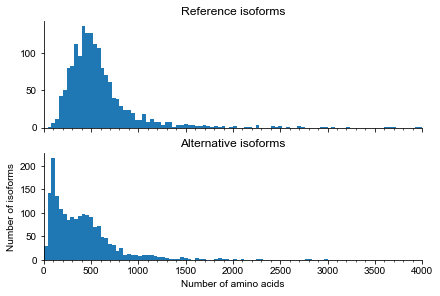

In [4]:
fig, axs = plt.subplots(2, 1, sharex=True)
fig.set_size_inches(w=6, h=4)
bins = 100
rng = (0, 4000)
axs[0].hist([len(tf.reference_isoform.aa_seq) for tf in tfs.values()],
            bins=bins,
            range=rng)
axs[0].set_title('Reference isoforms')
axs[1].hist([len(alt_iso.aa_seq) for tf in tfs.values() for alt_iso in tf.alternative_isoforms],
            bins=bins,
            range=rng)
axs[1].set_title('Alternative isoforms')
axs[1].set_xlabel('Number of amino acids')
axs[1].set_ylabel('Number of isoforms')
axs[1].set_xticks(range(0, 4000 + 1, 500))
axs[1].set_xticks(range(0, 4000, 100), minor=True)
axs[1].set_xlim(*rng)
for ax in axs:
    for pos in ['top', 'right']:
        ax.spines[pos].set_visible(False)
fig.savefig('../figures/n-aa-per-isoform_GENCODE.pdf',
            bbox_inches='tight')

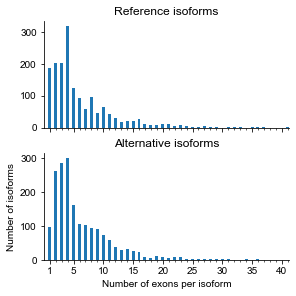

In [5]:
# exons per isoform
fig, axs = plt.subplots(2, 1, sharex=True)
fig.set_size_inches(w=4, h=4)
most_exons = max(len(iso.exons) for tf in tfs.values() for iso in tf.orfs)
bins = most_exons
axs[0].hist([len(tf.reference_isoform.exons) for tf in tfs.values()],
            bins=most_exons * 2 - 1,
            range=(0.75, most_exons + 0.25))
axs[0].set_title('Reference isoforms')
axs[1].hist([len(alt_iso.exons) for tf in tfs.values() for alt_iso in tf.alternative_isoforms],
            bins=most_exons * 2 - 1,
            range=(0.75, most_exons + 0.25))
axs[1].set_title('Alternative isoforms')
axs[1].set_xlabel('Number of exons per isoform')
axs[1].set_ylabel('Number of isoforms')
axs[1].set_xticks([1] + list(range(5, most_exons + 1, 5)))
axs[1].set_xticks(range(1, most_exons + 1), minor=True)
axs[1].set_xlim(0, most_exons + 0.25)
for ax in axs:
    for pos in ['top', 'right']:
        ax.spines[pos].set_visible(False)
fig.savefig('../figures/n-exons-per-isoform_GENCODE.pdf',
            bbox_inches='tight')

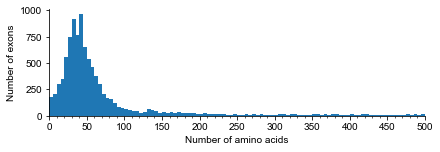

In [6]:
# size of exons
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(w=6, h=2)
bins = 100
rng = (0, 500)
ax.hist([len(exon) / 3 for tf in tfs.values() for exon in tf.reference_isoform.exons],
            bins=bins,
            range=rng)
ax.set_xlabel('Number of amino acids')
ax.set_ylabel('Number of exons')
ax.set_xticks(range(0, 500 + 1, 50))
ax.set_xticks(range(0, 500, 10), minor=True)
ax.set_xlim(*rng)
for pos in ['top', 'right']:
    ax.spines[pos].set_visible(False)
fig.savefig('../figures/n-aa-per-exon_GENCODE.pdf',
            bbox_inches='tight')

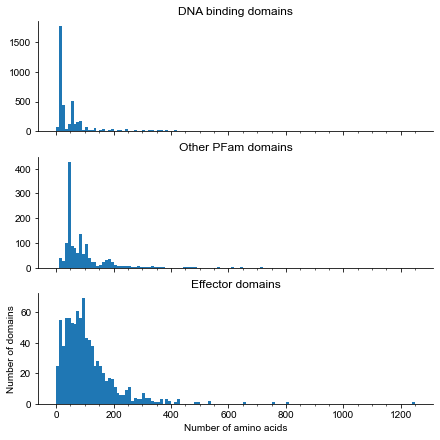

In [7]:
# size of domains split by DBD, other pfam and effector

def is_DBD(domain):
    return (domain.accession in dbd['pfam'].values) or domain.accession.startswith('C2H2_ZF_array')

n_aa_dbd = [len(dom) for tf in tfs.values() for dom in tf.reference_isoform.aa_seq_features if is_DBD(dom)]
n_aa_pfam = [len(dom) for tf in tfs.values() for dom in tf.reference_isoform.aa_seq_features if not is_DBD(dom) and dom.category == 'Pfam_domain']
n_aa_effector = [len(dom) for tf in tfs.values() for dom in tf.reference_isoform.aa_seq_features if not is_DBD(dom) and dom.category == 'effector_domain']

fig, axs = plt.subplots(3, 1, sharex=True)
fig.set_size_inches(h=6, w=6)
x_max = 1250
n_bins = 125
for n, ax in zip([n_aa_dbd, n_aa_pfam, n_aa_effector], axs):
    ax.hist(n, bins=n_bins, range=(0.5, x_max + 0.5))
    for pos in ['top', 'right']:
        ax.spines[pos].set_visible(False)
axs[0].set_title('DNA binding domains')
axs[1].set_title('Other PFam domains')
axs[2].set_title('Effector domains')
axs[2].set_xticks(range(0, x_max + 1, 50), minor=True)
axs[2].set_ylabel('Number of domains')
axs[2].set_xlabel('Number of amino acids')
fig.savefig('../figures/n_aa_per_domain_GENCODE.pdf',
            bbox_inches='tight')

In [8]:
# linking domains to exons
# TODO: move to isolib
def n_exon_per_domain(iso, dom):
    # TODO: this is inefficient
    coord_to_exon = {pos: exon.exon_number_on_gene for exon in iso.exons for pos in range(exon.start, exon.end)}
    # TODO: check this dom start end is correct
    return len({coord_to_exon[nt] for aa in iso.residues[dom.start:dom.end] for nt in aa.coords})

def f_exon_per_domain(iso, dom):
    # TODO: this is inefficient
    coord_to_exon = {pos: i for i, exon in enumerate(iso.exons) for pos in range(exon.start, exon.end)}
    # TODO: check this dom start end is correct
    exon_numbers = [coord_to_exon[nt] for aa in iso.residues[dom.start:dom.end] for nt in aa.coords]
    f = 0
    for i in set(exon_numbers):
        f += exon_numbers.count(i) / len(iso.exons[i])
    return f

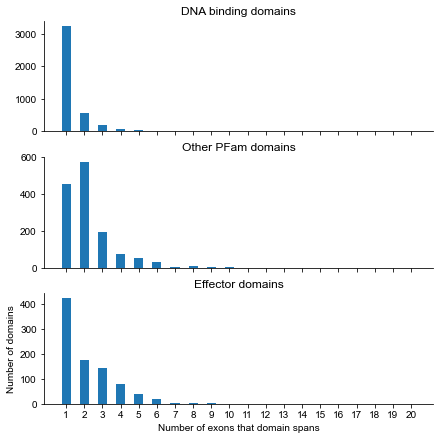

In [9]:
n_exon_dbd = [n_exon_per_domain(tf.reference_isoform, dom) for tf in tfs.values() for dom in tf.reference_isoform.aa_seq_features if is_DBD(dom)]
n_exon_pfam = [n_exon_per_domain(tf.reference_isoform, dom) for tf in tfs.values() for dom in tf.reference_isoform.aa_seq_features if not is_DBD(dom) and dom.category == 'Pfam_domain']
n_exon_effector = [n_exon_per_domain(tf.reference_isoform, dom) for tf in tfs.values() for dom in tf.reference_isoform.aa_seq_features if not is_DBD(dom) and dom.category == 'effector_domain']

fig, axs = plt.subplots(3, 1, sharex=True)
fig.set_size_inches(h=6, w=6)
x_max = max(n_exon_dbd + n_exon_pfam + n_exon_effector)
n_bins = x_max * 2 - 1
for n, ax in zip([n_exon_dbd, n_exon_pfam, n_exon_effector], axs):
    ax.hist(n, bins=n_bins, range=(0.75, x_max + 0.25))
    for pos in ['top', 'right']:
        ax.spines[pos].set_visible(False)
axs[0].set_title('DNA binding domains')
axs[1].set_title('Other PFam domains')
axs[2].set_title('Effector domains')
axs[2].set_xticks(range(1, x_max + 1))
axs[2].set_ylabel('Number of domains')
axs[2].set_xlabel('Number of exons that domain spans')
fig.savefig('../figures/n_exon_per_domain_GENCODE.pdf',
            bbox_inches='tight')

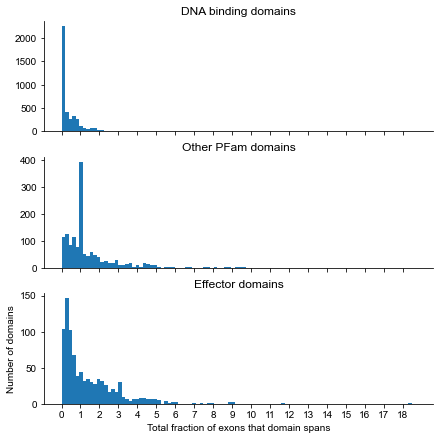

In [10]:
f_exon_dbd = [f_exon_per_domain(tf.reference_isoform, dom) for tf in tfs.values() for dom in tf.reference_isoform.aa_seq_features if is_DBD(dom)]
f_exon_pfam = [f_exon_per_domain(tf.reference_isoform, dom) for tf in tfs.values() for dom in tf.reference_isoform.aa_seq_features if not is_DBD(dom) and dom.category == 'Pfam_domain']
f_exon_effector = [f_exon_per_domain(tf.reference_isoform, dom) for tf in tfs.values() for dom in tf.reference_isoform.aa_seq_features if not is_DBD(dom) and dom.category == 'effector_domain']

fig, axs = plt.subplots(3, 1, sharex=True)
fig.set_size_inches(h=6, w=6)
x_max = max(f_exon_dbd + f_exon_pfam + f_exon_effector)
n_bins = 100
for n, ax in zip([f_exon_dbd, f_exon_pfam, f_exon_effector], axs):
    ax.hist(n, bins=n_bins, range=(0., x_max + 0.25))
    for pos in ['top', 'right']:
        ax.spines[pos].set_visible(False)
axs[0].set_title('DNA binding domains')
axs[1].set_title('Other PFam domains')
axs[2].set_title('Effector domains')
axs[2].set_xticks(range(0, int(x_max + 1)))
axs[2].set_ylabel('Number of domains')
axs[2].set_xlabel('Total fraction of exons that domain spans')
fig.savefig('../figures/f_exon_per_domain_GENCODE.pdf',
            bbox_inches='tight')

In [11]:
# investigate the spike in the other PFam domains
single_exon_doms = [dom for tf in tfs.values() for dom in tf.reference_isoform.aa_seq_features 
                if not is_DBD(dom) 
                and dom.category == 'Pfam_domain'
                and f_exon_per_domain(tf.reference_isoform, dom) < 1.1
                and f_exon_per_domain(tf.reference_isoform, dom) > 0.9
                and n_exon_per_domain(tf.reference_isoform, dom) == 1]
Counter([d.name for d in single_exon_doms])

Counter({'SCAN': 2,
         'Myc_N': 1,
         'PHD': 3,
         'PAS_11': 1,
         'T-box_assoc': 2,
         'KRAB': 29,
         'DUF3371': 4,
         'SSXRD': 1,
         'Caudal_act': 2,
         'Hox9_act': 3,
         'GATA-N': 1,
         'FLYWCH_N': 1})

In [12]:
%%time
df_null = pd.concat([g.null_fraction_per_aa_feature(g.orfs[0].name) for g in tfs.values()])
df = pd.merge(df, df_null, how='left', on=['gene', 'ref_iso', 'alt_iso', 'length'])

CPU times: user 1min 54s, sys: 944 ms, total: 1min 55s
Wall time: 1min 58s


In [13]:
for name, tf in tfs.items():
    if len(tf.orfs) < 2:
        continue
    if 'F' in tf.pairwise_changes_relative_to_reference(tf.orfs[0].name, tf.orfs[1].name):
        print(name)
        break

ZBTB8A


In [14]:
print(len({d for d in dbd_acc if not d.startswith('C2H2_ZF_array_')}) + 1, 'different DNA binding domain types')

160 different DNA binding domain types


In [15]:
len({k for k, v in clans.items() if v in dbd['clan'].values})

912

In [16]:
# random shuffle
# this will take a long time
rnd = []
for g in tqdm.tqdm(tfs.values()):
    rnd.append(g.random_aa_seq_feature_shuffle(g.orfs[0].name, n=100, subset=dbd_acc))
rnd = pd.concat(rnd)

100%|██████████| 1635/1635 [13:44<00:00,  1.98it/s] 


In [17]:
rnd['is_DBD'] = rnd['accession'].isin(dbd['pfam'].values) | rnd['accession'].str.startswith('C2H2_ZF_array')
rnd['is_affected'] = (rnd['deletion'] + rnd['insertion'] + rnd['frameshift']) > 0

In [19]:
# TMP just to fix problem from renaming
df['is_affected'] = df['is_affected_at_all']

False    1162
True      986
Name: is_affected, dtype: int64


<AxesSubplot: ylabel='is_affected'>

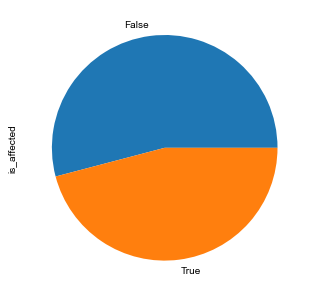

In [20]:
print(df.loc[df['is_DBD'], :].groupby('alt_iso')['is_affected'].any().value_counts())
df.loc[df['is_DBD'], :].groupby('alt_iso')['is_affected'].any().value_counts().plot.pie()

In [21]:
df['is_DBD'].sum()

5934

In [22]:
rnd['is_DBD'].sum()

593400

<AxesSubplot: ylabel='is_affected'>

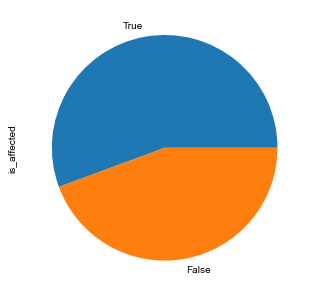

In [23]:
rnd.loc[rnd['is_DBD'], :].groupby(['alt_iso', 'random_sample'])['is_affected'].any().value_counts().plot.pie()

<ipython-input-26-55ebac6d4023>:3: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  (rnd.loc[rnd['is_DBD'], :]
<ipython-input-26-55ebac6d4023>:8: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  print(rnd.loc[rnd['is_DBD'], :]


1195.22


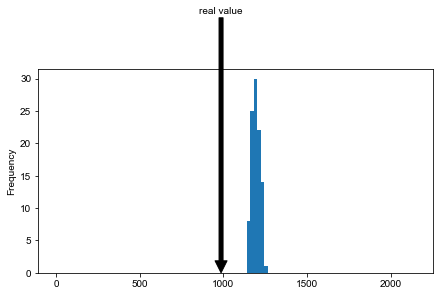

In [26]:
n = df.loc[df['is_DBD'], 'alt_iso'].nunique()
true_k = df.loc[df['is_DBD'], :].groupby('alt_iso')['is_affected'].any().sum()
(rnd.loc[rnd['is_DBD'], :]
    .groupby(['random_sample', 'alt_iso'])['is_affected']
    .any()
    .sum(level=0)
    .plot.hist(range=(0, n), bins=100))
print(rnd.loc[rnd['is_DBD'], :]
    .groupby(['random_sample', 'alt_iso'])['is_affected']
    .any()
    .sum(level=0).mean())
plt.annotate(xy=(true_k, 0),
                text='real value',
                xytext=(true_k, 40),  # TODO: change y position
                arrowprops={'color': 'black'},
                ha='center')
plt.savefig('../figures/DBD_affected_100_randomizations.pdf',
            bbox_inches='tight')

In [27]:
(len(tfs),
 sum(len(tf.orfs) > 1 for tf in tfs.values()),
 len([tf for tf in tfs.values() if any(len(orf.aa_seq_features) >= 1 for orf in tf.orfs)]),
 df['gene'].nunique(), 
 df.loc[df['is_DBD'], 'gene'].nunique())

(1635, 992, 1624, 967, 842)

In [32]:
# TMP fix for renaming
df['null_fraction_affected'] = df['null_fraction_affected_at_all'] 

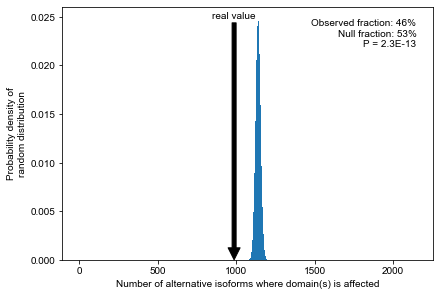

In [33]:
def domain_disruption_significance_plot(df, ax=None):
    if ax is None:
        ax = plt.gca()
    n = df['alt_iso'].nunique()
    true_k = df.groupby('alt_iso')['is_affected'].any().sum()

    def prob_or(probabilities):
        return 1 - (np.prod(1 - probabilities))

    null_p = df.groupby('alt_iso')['null_fraction_affected'].apply(prob_or).values
    pval = PoiBin(null_p).cdf(true_k)
    pmf = PoiBin(null_p).pmf(range(n))
    ax.bar(x=range(n),
            height=pmf,
            width=1.)
    ax.annotate(xy=(true_k, 0),
                text='real value',
                xytext=(true_k, max(pmf)),
                arrowprops={'color': 'black'},
                ha='center')
    ax.set_ylabel('Probability density of\nrandom distribution')
    ax.set_xlabel('Number of alternative isoforms where domain(s) is affected')
    ax.text(n,
            pmf.max(),
            'Observed fraction: {:.0%}\nNull fraction: {:.0%}\nP = {:.1E}'.format(true_k / n, pmf.argmax() / n, pval),
            ha='right',
            va='top')

domain_disruption_significance_plot(df.loc[df['is_DBD'], :])
plt.savefig('../figures/all_DBD_affected_random_dist.pdf', bbox_inches='tight')

In [34]:
df.loc[df['is_DBD'], 'alt_iso'].nunique()

2148

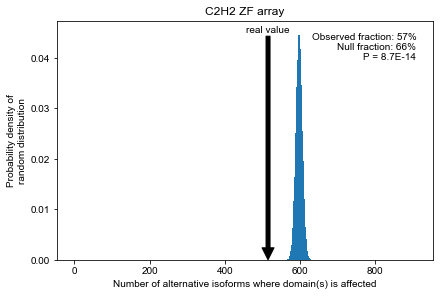

In [35]:
domain_disruption_significance_plot(df.loc[df['accession'].str.startswith('C2H2_ZF_array'), :])
plt.title('C2H2 ZF array')
plt.savefig('../figures/C2H2_ZF_array_affected_random_dist.pdf', bbox_inches='tight')

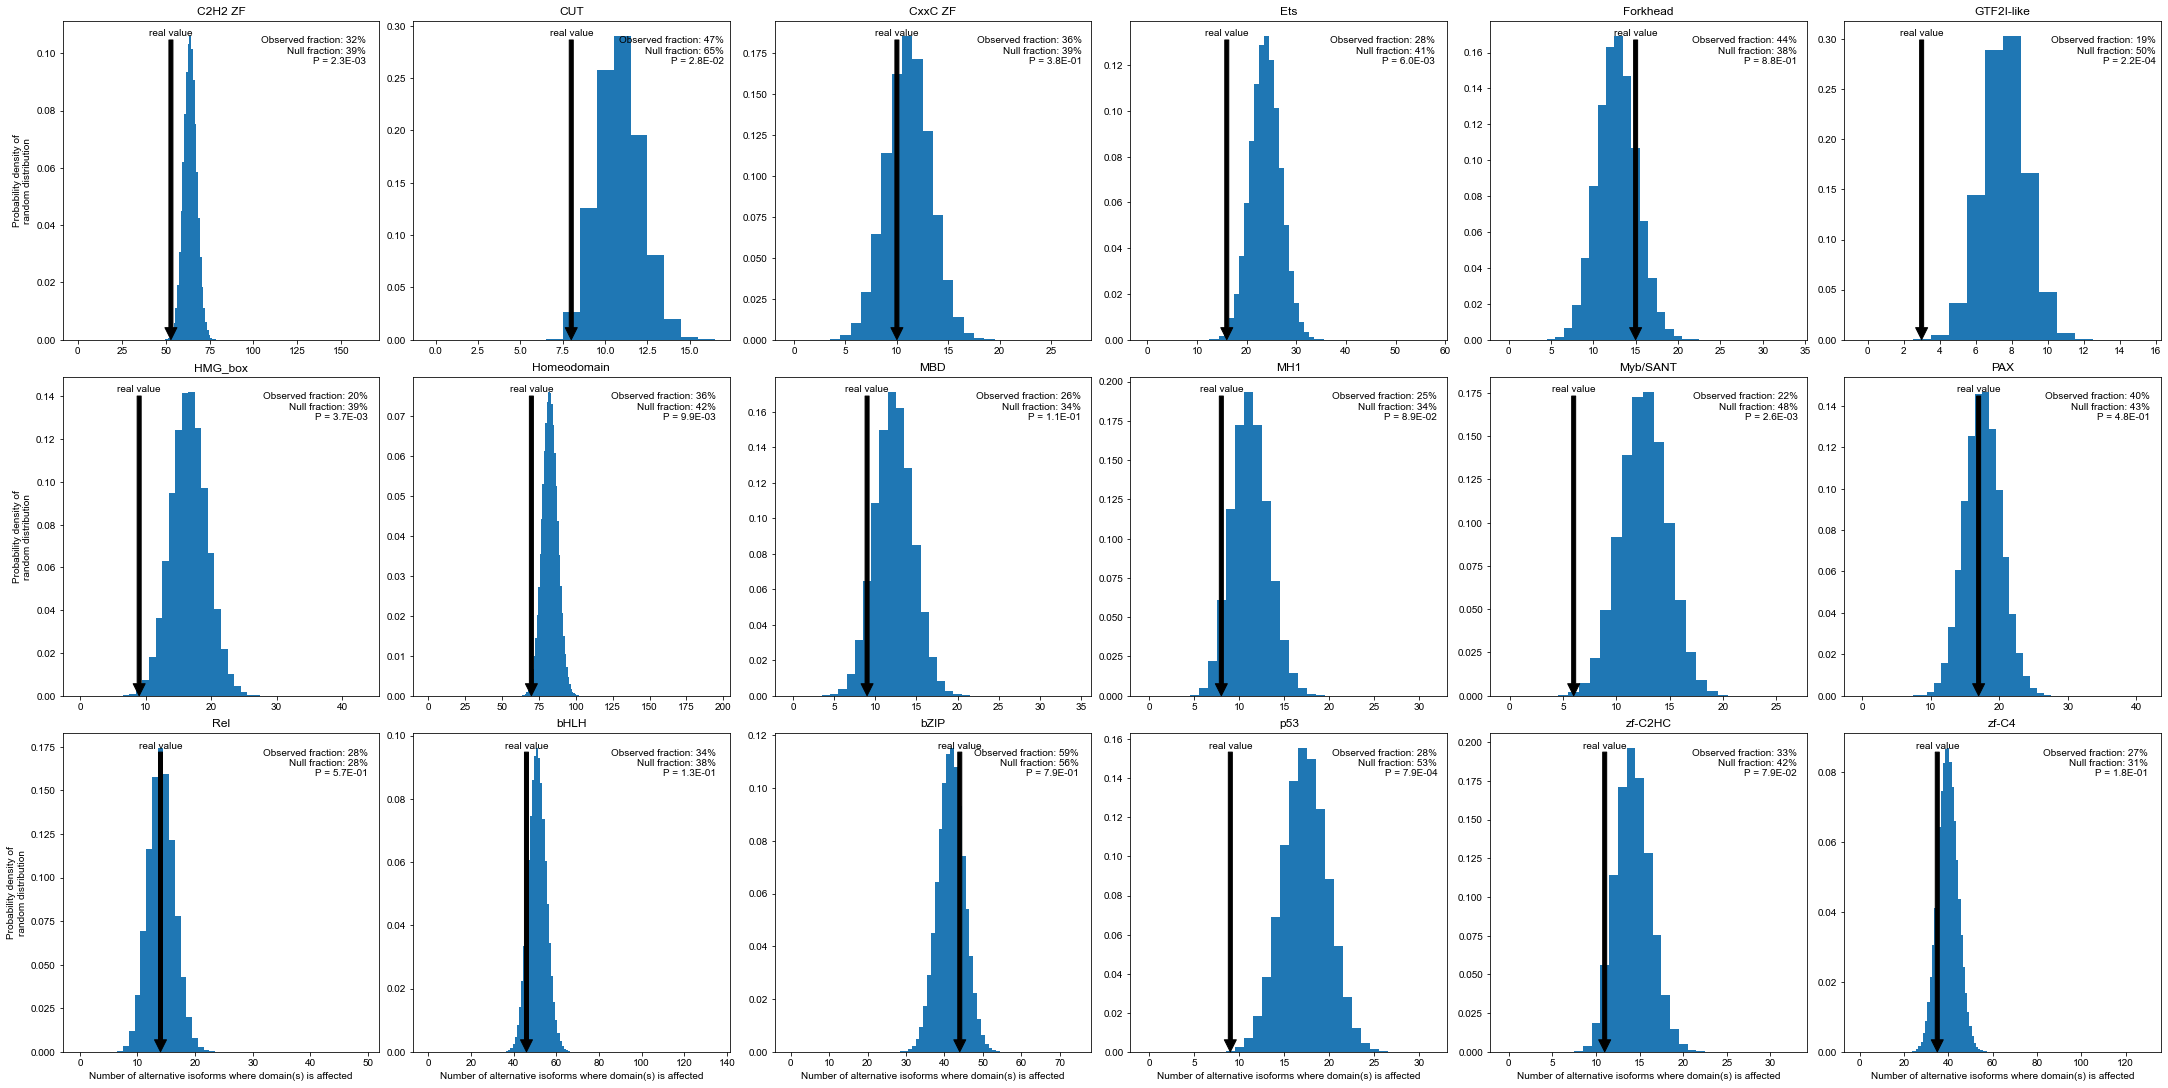

In [37]:
above_size_cutoff = (dbd['num_genes'] >= 30)
n_dbd = above_size_cutoff.sum()
fig, axes = plt.subplots(3, 6)
fig.set_size_inches(5 * 6, 5 * 3)
for (_i, row), ax in zip(dbd.loc[above_size_cutoff].iterrows(), axes.flatten()):
    ax.set_title(row['dbd'])
    domain_disruption_significance_plot(df.loc[df['accession'] == row['pfam'], :],
                                        ax=ax)
for ax in axes[:, 1:].flatten():
    ax.set_ylabel('')
for ax in axes[:-1, :].flatten():
    ax.set_xlabel('')
plt.savefig('../figures/different_DBDs_affected_random_dist.pdf', bbox_inches='tight')

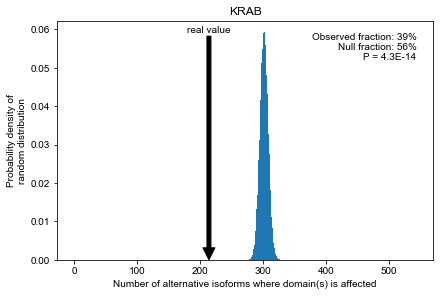

In [38]:
fig, ax = plt.subplots(1, 1)
ax.set_title('KRAB')
domain_disruption_significance_plot(df.loc[df['accession'] == 'PF01352', :],
                                    ax=ax)
plt.savefig('../figures/KRAB_affected_random_dist.pdf', bbox_inches='tight')

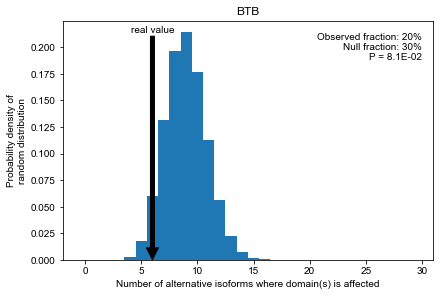

In [39]:
fig, ax = plt.subplots(1, 1)
ax.set_title('BTB')
domain_disruption_significance_plot(df.loc[df['accession'] == 'PF00651', :],
                                    ax=ax)
plt.savefig('../figures/BTB_affected_random_dist.pdf', bbox_inches='tight')

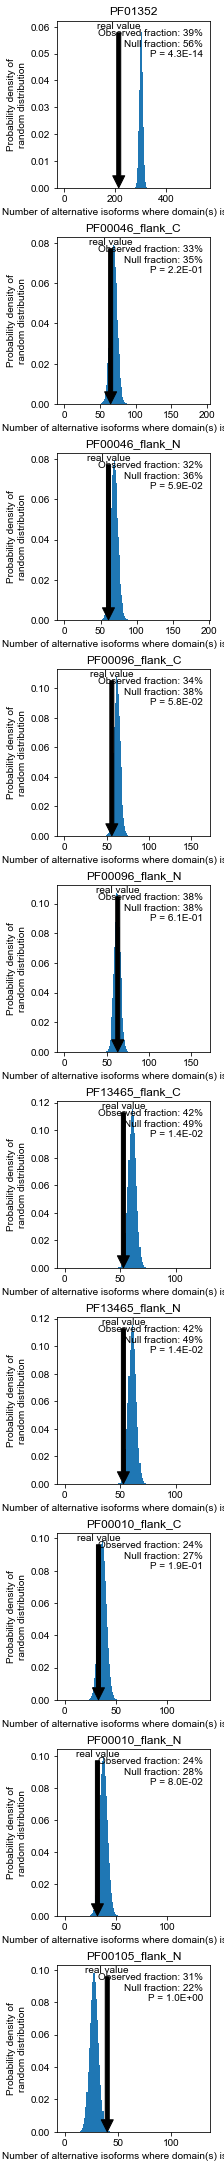

In [40]:
fig, axes = plt.subplots(10, 1)
fig.set_size_inches(3, 30)
for pfam_ac, ax in zip(df.loc[~df['is_DBD'], :].groupby('accession')['gene'].nunique().sort_values(ascending=False).head(10).index, axes):
    ax.set_title(pfam_ac)
    domain_disruption_significance_plot(df.loc[df['accession'] == pfam_ac, :],
                                    ax=ax)

In [41]:
pfam = pd.read_csv('../data/external/Pfam-A.clans.tsv',
                   sep='\t',
                   names=['pfam_accession', 'clan', 'clan_name', 'short_name', 'name'])

In [42]:
df.loc[df['accession'].str.startswith('C2H2_ZF_array'), 'accession'] = 'C2H2_ZF_array'
doms = (df.loc[(df['category'] == 'Pfam_domain') | 
              (df['category'] == 'ZF_array'), :]
              .groupby('accession')
              ['alt_iso']
              .nunique()
              .to_frame(name='n_alt_iso'))
for c in [c for c in df.columns if c.startswith('is_affected_')]:
    doms['n_' + c] = (df.loc[(df['category'] == 'Pfam_domain') |
                        (df['category'] == 'ZF_array'), :]
                        .groupby(['accession', 'alt_iso'])
                        [c]
                        .any()
                        .sum(level='accession'))
    doms['f_' + c] = doms['n_' + c] / doms['n_alt_iso']
doms = doms.sort_values('n_alt_iso', ascending=False)
    
def prob_or(probabilities):
    return 1 - (np.prod(1 - probabilities))
        

def null_quantile(values, q):
    n = len(values.values)
    for i, v in enumerate(PoiBin(values.values).cdf(range(n + 1))):
        if v >= q:
            return i / n


for null_col in [c for c in df.columns if c.startswith('null_fraction_')]:
    null_p = (df.loc[(df['category'] == 'Pfam_domain') |
                    (df['category'] == 'ZF_array'), :]
                .groupby(['accession', 'alt_iso'])
                [null_col]
                .apply(prob_or))
    doms[null_col + '_99CI_low'] = null_p.groupby('accession').apply(null_quantile, 0.01)
    doms[null_col + '_99CI_high'] = null_p.groupby('accession').apply(null_quantile, 0.99)
    doms[null_col + '_center'] = null_p.groupby('accession').apply(null_quantile, 0.5)

<ipython-input-42-d645084ebfec>:9: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  doms['n_' + c] = (df.loc[(df['category'] == 'Pfam_domain') |
<ipython-input-42-d645084ebfec>:9: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  doms['n_' + c] = (df.loc[(df['category'] == 'Pfam_domain') |
<ipython-input-42-d645084ebfec>:9: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  doms['n_' + c] = (df.loc[(df['category'] == 'Pfam_domain') |
<ipython-input-42-d645084ebfec>:9: FutureWarning: Using the level keyword in DataFrame a

In [43]:
doms['is_DBD'] = doms.index.isin(dbd['pfam'].values) | (doms.index == 'C2H2_ZF_array')
# Use the custom DBD names
doms.loc[doms['is_DBD'], 'domain_name'] = doms[doms['is_DBD']].index.map(dbd.set_index('pfam')['dbd'])
doms.loc[~doms['is_DBD'], 'domain_name'] = doms[~doms['is_DBD']].index.map(pfam.set_index('pfam_accession')['name'])
doms.loc[doms.index == 'C2H2_ZF_array', 'domain_name'] = ['C2H2 ZF array']
doms.head()

,n_alt_iso,n_is_affected_at_all,f_is_affected_at_all,n_is_affected_100pct,f_is_affected_100pct,n_is_affected_90pct,f_is_affected_90pct,n_is_affected_50pct,f_is_affected_50pct,n_is_affected_10pct,f_is_affected_10pct,null_fraction_affected_at_all_99CI_low,null_fraction_affected_at_all_99CI_high,null_fraction_affected_at_all_center,null_fraction_affected_100pct_99CI_low,null_fraction_affected_100pct_99CI_high,null_fraction_affected_100pct_center,null_fraction_affected_90pct_99CI_low,null_fraction_affected_90pct_99CI_high,null_fraction_affected_90pct_center,null_fraction_affected_50pct_99CI_low,null_fraction_affected_50pct_99CI_high,null_fraction_affected_50pct_center,null_fraction_affected_10pct_99CI_low,null_fraction_affected_10pct_99CI_high,null_fraction_affected_10pct_center,null_fraction_affected_99CI_low,null_fraction_affected_99CI_high,null_fraction_affected_center,is_DBD,domain_name
accession,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
C2H2_ZF_array,909,483,0.531353,372,0.409241,377,0.414741,410,0.451045,463,0.509351,0.564356,0.609461,0.587459,0.429043,0.459846,0.444444,0.435644,0.466447,0.451045,0.473047,0.506051,0.489549,0.532453,0.573157,0.552255,0.564356,0.609461,0.587459,True,C2H2 ZF array
PF01352,544,214,0.393382,99,0.181985,102,0.187500,149,0.273897,167,0.306985,0.525735,0.582721,0.555147,0.457721,0.512868,0.485294,0.463235,0.518382,0.490809,0.485294,0.542279,0.514706,0.511029,0.568015,0.538603,0.525735,0.582721,0.555147,False,KRAB box
PF00046,195,70,0.358974,47,0.241026,48,0.246154,56,0.287179,65,0.333333,0.364103,0.487179,0.425641,0.271795,0.379487,0.323077,0.276923,0.384615,0.333333,0.307692,0.425641,0.364103,0.348718,0.471795,0.410256,0.364103,0.487179,0.425641,True,Homeodomain
PF00096,164,53,0.323171,53,0.323171,53,0.323171,53,0.323171,53,0.323171,0.335366,0.445122,0.390244,0.317073,0.420732,0.365854,0.317073,0.420732,0.371951,0.323171,0.426829,0.378049,0.335366,0.439024,0.384146,0.335366,0.445122,0.390244,True,C2H2 ZF
PF00010,135,46,0.340741,14,0.103704,16,0.118519,28,0.207407,42,0.311111,0.311111,0.451852,0.377778,0.170370,0.288889,0.229630,0.192593,0.311111,0.251852,0.244444,0.370370,0.303704,0.288889,0.422222,0.355556,0.311111,0.451852,0.377778,True,bHLH


<ipython-input-44-c81738f8580d>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(data['domain_name'].values)
<ipython-input-44-c81738f8580d>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(data['domain_name'].values)
<ipython-input-44-c81738f8580d>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(data['domain_name'].values)
<ipython-input-44-c81738f8580d>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(data['domain_name'].values)
<ipython-input-44-c81738f8580d>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(data['domain_name'].values)


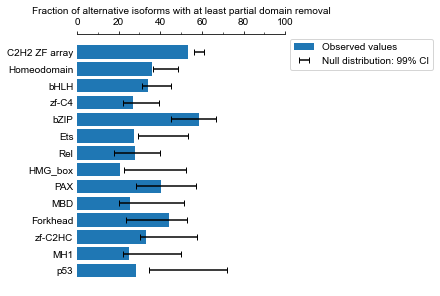

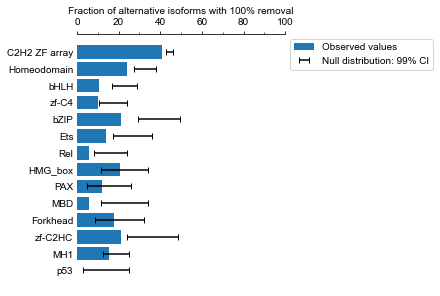

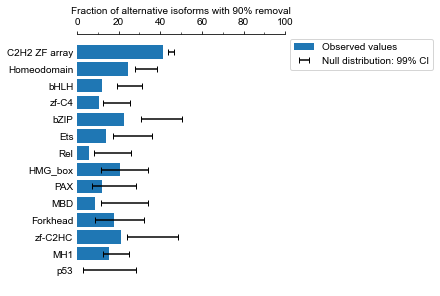

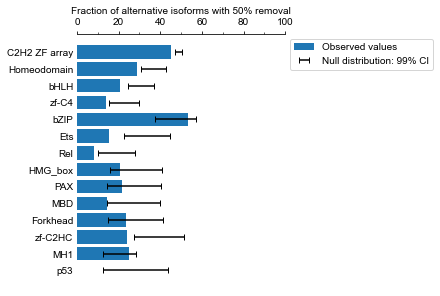

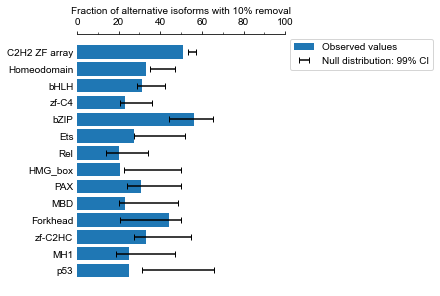

In [44]:
dom_affected_levels = [c[5:] for c in doms.columns if c.startswith('f_is_affected_')]
level_desc = {'affected_at_all': 'at least partial domain removal',
 'affected_100pct': '100% removal',
 'affected_90pct': '90% removal',
 'affected_50pct': '50% removal',
 'affected_10pct': '10% removal'}

for level in dom_affected_levels:
        fig, ax = plt.subplots(1, 1)
        cutoff = 30
        # removing C2H2-ZF clan becuase we look at the ZF arrays instead
        data = doms.loc[doms['is_DBD'] &
                        (doms['n_alt_iso'] >= cutoff) &
                        ~(doms.index.map(clans) == 'CL0361'), :].copy()
        ax.barh(data.index, 
                data[f'f_is_{level}'].values * 100,
                label='Observed values')
        ax.errorbar(y=data.index,
                x=data[f'null_fraction_{level}_center'].values * 100,
                xerr=[(data[f'null_fraction_{level}_center'] - data[f'null_fraction_{level}_99CI_low']).values * 100,
                        (data[f'null_fraction_{level}_99CI_high'] - data[f'null_fraction_{level}_center']).values * 100],
                                fmt='none',
                                capsize=3,
                                color='black',
                                label='Null distribution: 99% CI')
        ax.legend(loc='upper left', 
                bbox_to_anchor=(1, 1))
        ax.set_yticklabels(data['domain_name'].values)
        ax.set_xlim(0, 100)
        ax.set_ylim(ax.get_ylim()[::-1])
        ax.yaxis.set_tick_params(length=0)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.xaxis.tick_top()
        ax.set_xlabel(f'Fraction of alternative isoforms with {level_desc[level]}')
        ax.xaxis.set_label_position('top')
        ax.set_xticks(range(0, 101, 20))
        ax.set_xticks(range(0, 101, 10), minor=True)
        plt.savefig(f'../figures/DBD_{level}.pdf'.format(level),
                bbox_inches='tight')

In [50]:
# TMP
doms['f'] = doms['f_is_affected_at_all']
doms['null_center'] = doms['null_fraction_affected_at_all_center']
doms['null_99CI_high'] = doms['null_fraction_affected_at_all_99CI_high']
doms['null_99CI_low'] = doms['null_fraction_affected_at_all_99CI_low']

<ipython-input-51-f52d97c8ab90>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(data['domain_name'].values)


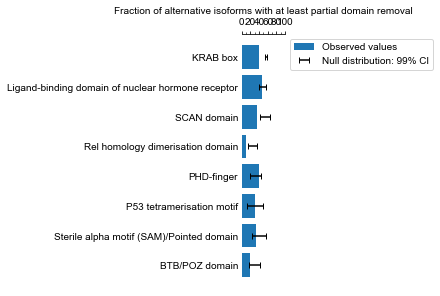

In [51]:
fig, ax = plt.subplots(1, 1)
cutoff = 30
data = doms.loc[~doms['is_DBD'] &
                (doms['n_alt_iso'] >= cutoff) &
                 ~(doms.index.map(clans) == 'CL0361'), :].copy()
ax.barh(data.index, 
        data['f'].values * 100,
        label='Observed values')
ax.errorbar(y=data.index,
            x=data['null_center'].values * 100,
            xerr=[(data['null_center'] - data['null_99CI_low']).values * 100,
                  (data['null_99CI_high'] - data['null_center']).values * 100],
                          fmt='none',
                          capsize=3,
                          color='black',
                        label='Null distribution: 99% CI')
ax.legend(loc='upper left', 
          bbox_to_anchor=(1, 1))
ax.set_yticklabels(data['domain_name'].values)
ax.set_xlim(0, 100)
ax.set_ylim(ax.get_ylim()[::-1])
ax.yaxis.set_tick_params(length=0)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.xaxis.tick_top()
ax.set_xlabel('Fraction of alternative isoforms with at least partial domain removal')
ax.xaxis.set_label_position('top')
ax.set_xticks(range(0, 101, 20))
ax.set_xticks(range(0, 101, 10), minor=True)
plt.savefig('../figures/other_domain_partial_removal.pdf',
            bbox_inches='tight')

<ipython-input-52-1d318eb24409>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(data['domain_name'].values)
<ipython-input-52-1d318eb24409>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(data['domain_name'].values)
<ipython-input-52-1d318eb24409>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(data['domain_name'].values)
<ipython-input-52-1d318eb24409>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(data['domain_name'].values)
<ipython-input-52-1d318eb24409>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(data['domain_name'].values)


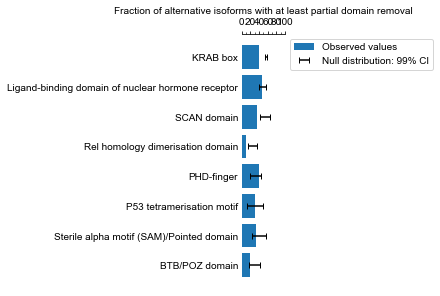

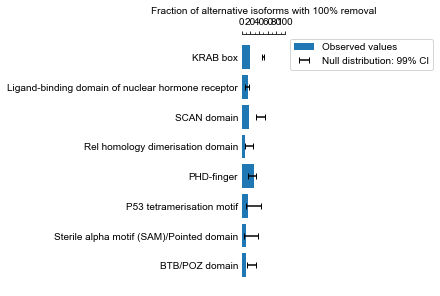

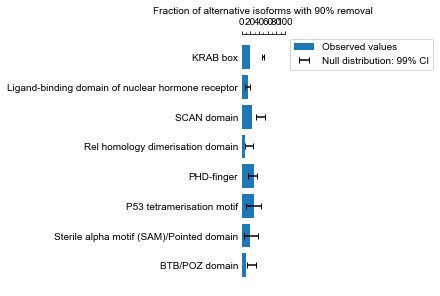

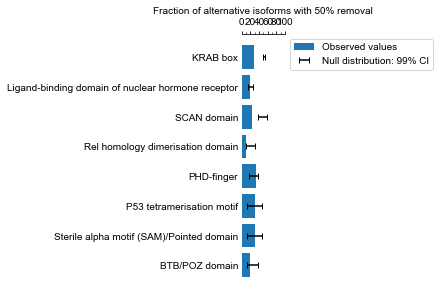

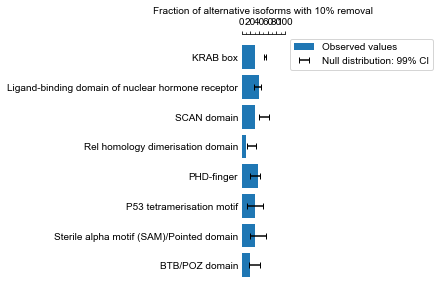

In [52]:
for level in dom_affected_levels:
        fig, ax = plt.subplots(1, 1)
        cutoff = 30
        # removing C2H2-ZF clan becuase we look at the ZF arrays instead
        data = doms.loc[~doms['is_DBD'] &
                        (doms['n_alt_iso'] >= cutoff) &
                        ~(doms.index.map(clans) == 'CL0361'), :].copy()
        ax.barh(data.index, 
                data[f'f_is_{level}'].values * 100,
                label='Observed values')
        ax.errorbar(y=data.index,
                x=data[f'null_fraction_{level}_center'].values * 100,
                xerr=[(data[f'null_fraction_{level}_center'] - data[f'null_fraction_{level}_99CI_low']).values * 100,
                        (data[f'null_fraction_{level}_99CI_high'] - data[f'null_fraction_{level}_center']).values * 100],
                                fmt='none',
                                capsize=3,
                                color='black',
                                label='Null distribution: 99% CI')
        ax.legend(loc='upper left', 
                bbox_to_anchor=(1, 1))
        ax.set_yticklabels(data['domain_name'].values)
        ax.set_xlim(0, 100)
        ax.set_ylim(ax.get_ylim()[::-1])
        ax.yaxis.set_tick_params(length=0)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.xaxis.tick_top()
        ax.set_xlabel(f'Fraction of alternative isoforms with {level_desc[level]}')
        ax.xaxis.set_label_position('top')
        ax.set_xticks(range(0, 101, 20))
        ax.set_xticks(range(0, 101, 10), minor=True)
        plt.savefig(f'../figures/other_domain_{level}.pdf'.format(level),
                bbox_inches='tight')

In [53]:
# all domains, all DBD, non-DBD
doms = df.groupby('is_DBD')['alt_iso'].nunique().to_frame(name='n_alt_iso')
for c in [c for c in df.columns if c.startswith('is_affected_')]:
    doms['n_' + c] = (df.groupby(['is_DBD', 'alt_iso'])
                        [c]
                        .any()
                        .sum(level='is_DBD'))
    doms['f_' + c] = doms['n_' + c] / doms['n_alt_iso']


doms = doms.sort_values('n_alt_iso', ascending=False)
    
def prob_or(probabilities):
    return 1 - (np.prod(1 - probabilities))
        

def null_quantile(values, q):
    n = len(values.values)
    for i, v in enumerate(PoiBin(values.values).cdf(range(n + 1))):
        if v >= q:
            return i / n


for null_col in [c for c in df.columns if c.startswith('null_fraction_')]:
    null_p = (df.groupby(['is_DBD', 'alt_iso'])
                [null_col]
                .apply(prob_or))
    doms[null_col + '_99CI_low'] = null_p.groupby('is_DBD').apply(null_quantile, 0.01)
    doms[null_col + '_99CI_high'] = null_p.groupby('is_DBD').apply(null_quantile, 0.99)
    doms[null_col + '_center'] = null_p.groupby('is_DBD').apply(null_quantile, 0.5)
doms.head()

<ipython-input-53-bc04a7ed6b88>:4: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  doms['n_' + c] = (df.groupby(['is_DBD', 'alt_iso'])
<ipython-input-53-bc04a7ed6b88>:4: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  doms['n_' + c] = (df.groupby(['is_DBD', 'alt_iso'])
<ipython-input-53-bc04a7ed6b88>:4: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  doms['n_' + c] = (df.groupby(['is_DBD', 'alt_iso'])
<ipython-input-53-bc04a7ed6b88>:4: FutureWarning: Using the level keyword in DataFrame and Series aggregations is d

,n_alt_iso,n_is_affected_at_all,f_is_affected_at_all,n_is_affected_100pct,f_is_affected_100pct,n_is_affected_90pct,f_is_affected_90pct,n_is_affected_50pct,f_is_affected_50pct,n_is_affected_10pct,f_is_affected_10pct,null_fraction_affected_at_all_99CI_low,null_fraction_affected_at_all_99CI_high,null_fraction_affected_at_all_center,null_fraction_affected_100pct_99CI_low,null_fraction_affected_100pct_99CI_high,null_fraction_affected_100pct_center,null_fraction_affected_90pct_99CI_low,null_fraction_affected_90pct_99CI_high,null_fraction_affected_90pct_center,null_fraction_affected_50pct_99CI_low,null_fraction_affected_50pct_99CI_high,null_fraction_affected_50pct_center,null_fraction_affected_10pct_99CI_low,null_fraction_affected_10pct_99CI_high,null_fraction_affected_10pct_center,null_fraction_affected_99CI_low,null_fraction_affected_99CI_high,null_fraction_affected_center
is_DBD,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
False,2326,1469,0.631556,878,0.377472,904,0.388650,1093,0.469905,1321,0.567928,0.605331,0.637145,0.621238,0.455288,0.484953,0.469905,0.460877,0.490542,0.475494,0.502150,0.532674,0.517197,0.567068,0.598882,0.582975,0.605331,0.637145,0.621238
True,2148,986,0.459032,682,0.317505,693,0.322626,791,0.368250,928,0.432030,0.513035,0.547486,0.530261,0.377561,0.406425,0.391527,0.385475,0.414804,0.399907,0.425047,0.455773,0.440410,0.485568,0.518622,0.501862,0.513035,0.547486,0.530261


In [54]:
df['category_a'] = np.nan
df.loc[df['is_DBD'], 'category_a'] = 'DBD'
df.loc[(df['category'] == 'Pfam_domain') & ~df['is_DBD'], 'category_a'] = 'Other Pfam domain'
df.loc[(df['category'] == 'effector_domain'), 'category_a'] = 'Effector domain'

In [55]:
doms.head()

,n_alt_iso,n_is_affected_at_all,f_is_affected_at_all,n_is_affected_100pct,f_is_affected_100pct,n_is_affected_90pct,f_is_affected_90pct,n_is_affected_50pct,f_is_affected_50pct,n_is_affected_10pct,f_is_affected_10pct,null_fraction_affected_at_all_99CI_low,null_fraction_affected_at_all_99CI_high,null_fraction_affected_at_all_center,null_fraction_affected_100pct_99CI_low,null_fraction_affected_100pct_99CI_high,null_fraction_affected_100pct_center,null_fraction_affected_90pct_99CI_low,null_fraction_affected_90pct_99CI_high,null_fraction_affected_90pct_center,null_fraction_affected_50pct_99CI_low,null_fraction_affected_50pct_99CI_high,null_fraction_affected_50pct_center,null_fraction_affected_10pct_99CI_low,null_fraction_affected_10pct_99CI_high,null_fraction_affected_10pct_center,null_fraction_affected_99CI_low,null_fraction_affected_99CI_high,null_fraction_affected_center
is_DBD,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
False,2326,1469,0.631556,878,0.377472,904,0.388650,1093,0.469905,1321,0.567928,0.605331,0.637145,0.621238,0.455288,0.484953,0.469905,0.460877,0.490542,0.475494,0.502150,0.532674,0.517197,0.567068,0.598882,0.582975,0.605331,0.637145,0.621238
True,2148,986,0.459032,682,0.317505,693,0.322626,791,0.368250,928,0.432030,0.513035,0.547486,0.530261,0.377561,0.406425,0.391527,0.385475,0.414804,0.399907,0.425047,0.455773,0.440410,0.485568,0.518622,0.501862,0.513035,0.547486,0.530261


<ipython-input-56-3ba3de5aa0dc>:4: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  doms['n_' + c] = (df.groupby(['category_a', 'alt_iso'])
<ipython-input-56-3ba3de5aa0dc>:4: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  doms['n_' + c] = (df.groupby(['category_a', 'alt_iso'])
<ipython-input-56-3ba3de5aa0dc>:4: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  doms['n_' + c] = (df.groupby(['category_a', 'alt_iso'])
<ipython-input-56-3ba3de5aa0dc>:4: FutureWarning: Using the level keyword in DataFrame and Series aggre

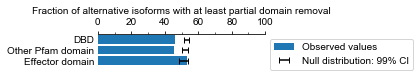

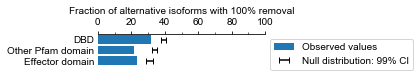

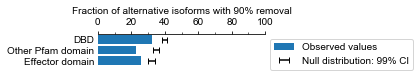

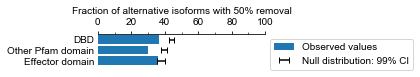

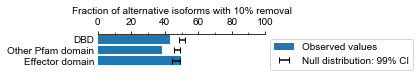

In [56]:
# split pfam into dbd and 
doms = df.groupby('category_a')['alt_iso'].nunique().to_frame(name='n_alt_iso')
for c in [c for c in df.columns if c.startswith('is_affected_')]:
    doms['n_' + c] = (df.groupby(['category_a', 'alt_iso'])
                        [c]
                        .any()
                        .sum(level='category_a'))
    doms['f_' + c] = doms['n_' + c] / doms['n_alt_iso']
doms = doms.sort_values('n_alt_iso', ascending=False)

    
def prob_or(probabilities):
    return 1 - (np.prod(1 - probabilities))
        

def null_quantile(values, q):
    n = len(values.values)
    for i, v in enumerate(PoiBin(values.values).cdf(range(n + 1))):
        if v >= q:
            return i / n


for null_col in [c for c in df.columns if c.startswith('null_fraction_')]:
    null_p = (df.groupby(['category_a', 'alt_iso'])
                [null_col]
                .apply(prob_or))
    doms[null_col + '_99CI_low'] = null_p.groupby('category_a').apply(null_quantile, 0.01)
    doms[null_col + '_99CI_high'] = null_p.groupby('category_a').apply(null_quantile, 0.99)
    doms[null_col + '_center'] = null_p.groupby('category_a').apply(null_quantile, 0.5)

data = doms.copy()
for level in dom_affected_levels:
        fig, ax = plt.subplots(1, 1)
        fig.set_size_inches(3, 0.6)
        # removing C2H2-ZF clan becuase we look at the ZF arrays instead
        ax.barh(data.index, 
                data[f'f_is_{level}'].values * 100,
                label='Observed values')
        ax.errorbar(y=data.index,
                x=data[f'null_fraction_{level}_center'].values * 100,
                xerr=[(data[f'null_fraction_{level}_center'] - data[f'null_fraction_{level}_99CI_low']).values * 100,
                        (data[f'null_fraction_{level}_99CI_high'] - data[f'null_fraction_{level}_center']).values * 100],
                                fmt='none',
                                capsize=3,
                                color='black',
                                label='Null distribution: 99% CI')
        ax.legend(loc='upper left', 
                bbox_to_anchor=(1, 1))
        ax.set_xlim(0, 100)
        ax.set_ylim(ax.get_ylim()[::-1])
        ax.yaxis.set_tick_params(length=0)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.xaxis.tick_top()
        ax.set_xlabel(f'Fraction of alternative isoforms with {level_desc[level]}')
        ax.xaxis.set_label_position('top')
        ax.set_xticks(range(0, 101, 20))
        ax.set_xticks(range(0, 101, 10), minor=True)
        plt.savefig(f'../figures/domain_categories_{level}.pdf'.format(level),
                bbox_inches='tight')

In [57]:
# split effector domain into AD/RD/BiF
path_effector_domains = '../data/external/Soto-et-al_MolCell_2022_Supplementary-tables.xlsx'
reg_dom = pd.read_excel(path_effector_domains, sheet_name="Table S2")
df['effector_domain_type'] = df['accession'].map(reg_dom.set_index('Effector domain ID')['Domain type'])

<ipython-input-58-7c2c2736fa95>:3: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  doms['n_' + c] = (df.groupby(['effector_domain_type', 'alt_iso'])
<ipython-input-58-7c2c2736fa95>:3: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  doms['n_' + c] = (df.groupby(['effector_domain_type', 'alt_iso'])
<ipython-input-58-7c2c2736fa95>:3: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  doms['n_' + c] = (df.groupby(['effector_domain_type', 'alt_iso'])
<ipython-input-58-7c2c2736fa95>:3: FutureWarning: Using the level keyword

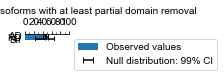

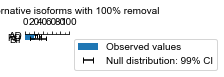

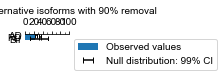

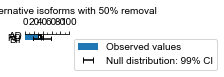

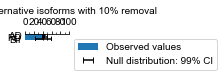

In [58]:
doms = df.groupby('effector_domain_type')['alt_iso'].nunique().to_frame(name='n_alt_iso')
for c in [c for c in df.columns if c.startswith('is_affected_')]:
    doms['n_' + c] = (df.groupby(['effector_domain_type', 'alt_iso'])
                        [c]
                        .any()
                        .sum(level='effector_domain_type'))
    doms['f_' + c] = doms['n_' + c] / doms['n_alt_iso']
doms = doms.sort_values('n_alt_iso', ascending=False)
    
def prob_or(probabilities):
    return 1 - (np.prod(1 - probabilities))
        

def null_quantile(values, q):
    n = len(values.values)
    for i, v in enumerate(PoiBin(values.values).cdf(range(n + 1))):
        if v >= q:
            return i / n


for null_col in [c for c in df.columns if c.startswith('null_fraction_')]:
    null_p = (df.groupby(['effector_domain_type', 'alt_iso'])
                [null_col]
                .apply(prob_or))
    doms[null_col + '_99CI_low'] = null_p.groupby('effector_domain_type').apply(null_quantile, 0.01)
    doms[null_col + '_99CI_high'] = null_p.groupby('effector_domain_type').apply(null_quantile, 0.99)
    doms[null_col + '_center'] = null_p.groupby('effector_domain_type').apply(null_quantile, 0.5)

data = doms.copy()
for level in dom_affected_levels:
        fig, ax = plt.subplots(1, 1)
        fig.set_size_inches(3, 0.6)
        # removing C2H2-ZF clan becuase we look at the ZF arrays instead
        ax.barh(data.index, 
                data[f'f_is_{level}'].values * 100,
                label='Observed values')
        ax.errorbar(y=data.index,
                x=data[f'null_fraction_{level}_center'].values * 100,
                xerr=[(data[f'null_fraction_{level}_center'] - data[f'null_fraction_{level}_99CI_low']).values * 100,
                        (data[f'null_fraction_{level}_99CI_high'] - data[f'null_fraction_{level}_center']).values * 100],
                                fmt='none',
                                capsize=3,
                                color='black',
                                label='Null distribution: 99% CI')
        ax.legend(loc='upper left', 
                bbox_to_anchor=(1, 1))
        ax.set_xlim(0, 100)
        ax.set_ylim(ax.get_ylim()[::-1])
        ax.yaxis.set_tick_params(length=0)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.xaxis.tick_top()
        ax.set_xlabel(f'Fraction of alternative isoforms with {level_desc[level]}')
        ax.xaxis.set_label_position('top')
        ax.set_xticks(range(0, 101, 20))
        ax.set_xticks(range(0, 101, 10), minor=True)
        plt.savefig(f'../figures/effector_domain_categories_{level}.pdf'.format(level),
                bbox_inches='tight')

In [59]:
reg_dom['N or S?'].value_counts()

S          351
N          239
N and S    214
Name: N or S?, dtype: int64

In [60]:
df['effector_domain_N_or_S'] = df['accession'].map(reg_dom.set_index('Effector domain ID')['N or S?'])

In [61]:
def domain_affected_plots(df, column, order=None):
    doms = df.groupby(column)['alt_iso'].nunique().to_frame(name='n_alt_iso')
    for c in [c for c in df.columns if c.startswith('is_affected_')]:
        doms['n_' + c] = (df.groupby([column, 'alt_iso'])
                            [c]
                            .any()
                            .sum(level=column))
        doms['f_' + c] = doms['n_' + c] / doms['n_alt_iso']
    doms = doms.sort_values('n_alt_iso', ascending=False)
        
    def prob_or(probabilities):
        return 1 - (np.prod(1 - probabilities))
            

    def null_quantile(values, q):
        n = len(values.values)
        for i, v in enumerate(PoiBin(values.values).cdf(range(n + 1))):
            if v >= q:
                return i / n


    for null_col in [c for c in df.columns if c.startswith('null_fraction_')]:
        null_p = (df.groupby([column, 'alt_iso'])
                    [null_col]
                    .apply(prob_or))
        doms[null_col + '_99CI_low'] = null_p.groupby(column).apply(null_quantile, 0.01)
        doms[null_col + '_99CI_high'] = null_p.groupby(column).apply(null_quantile, 0.99)
        doms[null_col + '_center'] = null_p.groupby(column).apply(null_quantile, 0.5)

    data = doms.copy()
    if order is not None:
        data = data.loc[order]
    for level in dom_affected_levels:
        fig, ax = plt.subplots(1, 1)
        fig.set_size_inches(w=3, h=0.15 * (data.shape[0] + 2))
        # removing C2H2-ZF clan becuase we look at the ZF arrays instead
        ax.barh(data.index, 
                data[f'f_is_{level}'].values * 100,
                label='Observed values')
        ax.errorbar(y=data.index,
                x=data[f'null_fraction_{level}_center'].values * 100,
                xerr=[(data[f'null_fraction_{level}_center'] - data[f'null_fraction_{level}_99CI_low']).values * 100,
                        (data[f'null_fraction_{level}_99CI_high'] - data[f'null_fraction_{level}_center']).values * 100],
                                fmt='none',
                                capsize=3,
                                color='black',
                                label='Null distribution: 99% CI')
        ax.legend(loc='upper left', 
                bbox_to_anchor=(1, 1))
        ax.set_xlim(0, 100)
        ax.set_ylim(ax.get_ylim()[::-1])
        ax.yaxis.set_tick_params(length=0)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.xaxis.tick_top()
        ax.set_xlabel(f'Fraction of alternative isoforms with {level_desc[level]}')
        ax.xaxis.set_label_position('top')
        ax.set_xticks(range(0, 101, 20))
        ax.set_xticks(range(0, 101, 10), minor=True)
        plt.savefig(f'../figures/{column}_{level}.pdf'.format(level),
                bbox_inches='tight')

<ipython-input-61-ee37946c1dce>:4: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  doms['n_' + c] = (df.groupby([column, 'alt_iso'])
<ipython-input-61-ee37946c1dce>:4: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  doms['n_' + c] = (df.groupby([column, 'alt_iso'])
<ipython-input-61-ee37946c1dce>:4: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  doms['n_' + c] = (df.groupby([column, 'alt_iso'])
<ipython-input-61-ee37946c1dce>:4: FutureWarning: Using the level keyword in DataFrame and Series aggregations is depreca

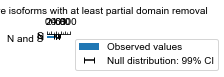

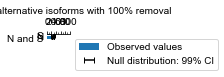

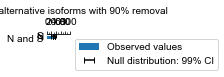

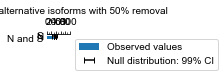

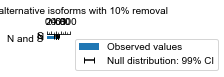

In [62]:
df['effector_domain_necessary_or_sufficient'] = df['accession'].map(reg_dom.set_index('Effector domain ID')['N or S?'])
domain_affected_plots(df, 'effector_domain_necessary_or_sufficient')

In [63]:
reg_dom['Confidence (H, M or L)'].value_counts()

H    532
M    275
L    116
Name: Confidence (H, M or L), dtype: int64

<ipython-input-61-ee37946c1dce>:4: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  doms['n_' + c] = (df.groupby([column, 'alt_iso'])
<ipython-input-61-ee37946c1dce>:4: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  doms['n_' + c] = (df.groupby([column, 'alt_iso'])
<ipython-input-61-ee37946c1dce>:4: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  doms['n_' + c] = (df.groupby([column, 'alt_iso'])
<ipython-input-61-ee37946c1dce>:4: FutureWarning: Using the level keyword in DataFrame and Series aggregations is depreca

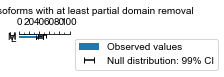

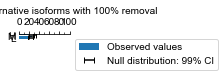

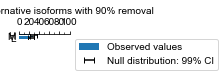

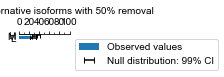

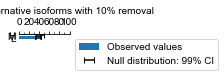

In [64]:
df['effector_domain_confidence'] = df['accession'].map(reg_dom.set_index('Effector domain ID')['Confidence (H, M or L)'])
domain_affected_plots(df, 'effector_domain_confidence')


<ipython-input-61-ee37946c1dce>:4: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  doms['n_' + c] = (df.groupby([column, 'alt_iso'])
<ipython-input-61-ee37946c1dce>:4: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  doms['n_' + c] = (df.groupby([column, 'alt_iso'])
<ipython-input-61-ee37946c1dce>:4: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  doms['n_' + c] = (df.groupby([column, 'alt_iso'])
<ipython-input-61-ee37946c1dce>:4: FutureWarning: Using the level keyword in DataFrame and Series aggregations is depreca

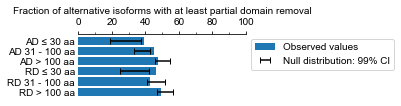

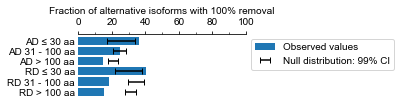

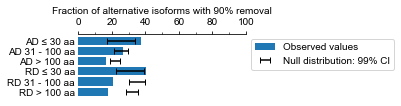

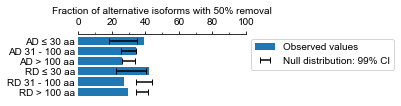

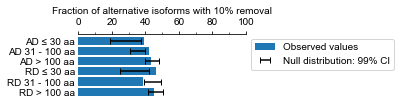

In [65]:
# size restriction
df['effector_domain_n_aa'] = df['accession'].map(reg_dom.set_index('Effector domain ID')['Sequence'].str.len())
# 4-30, 31-100, > 100
def bin_length(n):
    if n <= 30:
        return '≤ 30 aa'
    elif n <= 100:
        return '31 - 100 aa'
    else:
        return '> 100 aa'

df['effector_domain_size_bin'] = df['effector_domain_type'] + ' ' + df['effector_domain_n_aa'].apply(bin_length)
order = [a + b for a in ['AD ', 'RD '] for b in ['≤ 30 aa', '31 - 100 aa', '> 100 aa']]
domain_affected_plots(df.loc[df['effector_domain_size_bin'].isin(order), :],
                      'effector_domain_size_bin',
                      order=order)

In [66]:
df['pfam_clan'] = df['accession'].map(clans)

<ipython-input-61-ee37946c1dce>:4: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  doms['n_' + c] = (df.groupby([column, 'alt_iso'])
<ipython-input-61-ee37946c1dce>:4: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  doms['n_' + c] = (df.groupby([column, 'alt_iso'])
<ipython-input-61-ee37946c1dce>:4: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  doms['n_' + c] = (df.groupby([column, 'alt_iso'])
<ipython-input-61-ee37946c1dce>:4: FutureWarning: Using the level keyword in DataFrame and Series aggregations is depreca

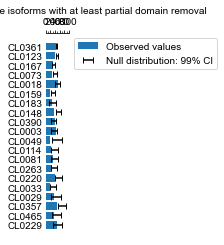

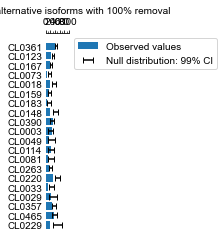

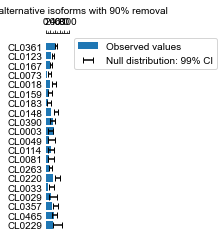

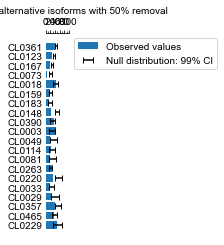

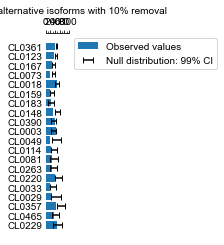

In [67]:
domain_affected_plots(df,
                      'pfam_clan',
                      order=df['pfam_clan'].value_counts().head(20).index.values)